# In Situ Comparison

In [1]:
import sys
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import glob
import calendar
import seaborn as sns
sys.path.append('/g/data/qz03/wp3/code/git-repo')
from utils import *

## Domain and data availability plots

### Solar data availability

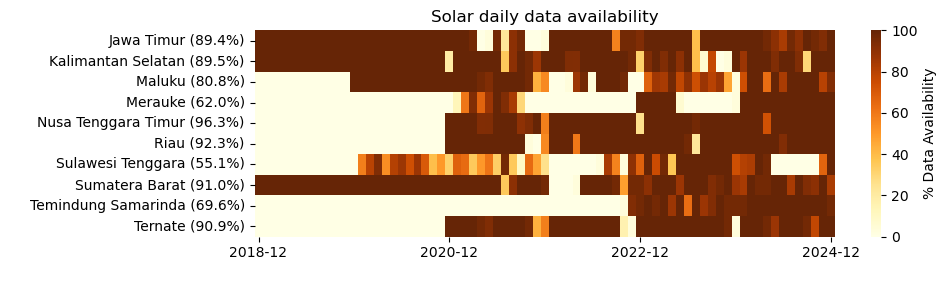

<Figure size 640x480 with 0 Axes>

In [161]:
solar_station_latlon_df = pd.read_csv('/g/data/qz03/wp3/data/obs/solar/station_metadata.csv').drop(columns=['No']).dropna()

files = ['/g/data/qz03/wp3/data/obs/solar/'+station_csv for station_csv in os.listdir('/g/data/qz03/wp3/data/obs/solar') if 'station_metadata' not in station_csv]
dfs = {f.split('/')[-1].replace('.csv',''): pd.read_csv(f) for f in files}

months_list = []
for df in dfs.values():
    df['Date'] = pd.to_datetime(df['Date'])
    months_list.append(df['Date'].dt.tz_convert(None).dt.to_period('M').drop_duplicates())

all_months = pd.Index(pd.concat(months_list).drop_duplicates()).sort_values()

availability = pd.DataFrame(index=dfs.keys(), columns=all_months.astype(str))
for station, df in dfs.items():
    df['year_month'] = df['Date'].dt.tz_convert(None).dt.to_period('M')
    total_per_month = df.groupby('year_month').size()
    avail_per_month = df.groupby('year_month')['GHI_sum'].apply(lambda x: (x.notna() & (x != 0)).sum()) 
    pct = (avail_per_month / total_per_month).reindex(all_months, fill_value=0) * 100
    availability.loc[station] = pct.values
    
availability.index = availability.index.str[:5]
new_index = []
for station, df in dfs.items():
    total = len(df)
    available = (df['GHI_sum'].notna() & (df['GHI_sum'] != 0)).sum()
    percent = (available / total) * 100 if total > 0 else 0
    label = f"{station.split('_')[1]} ({percent:.1f}%)"
    new_index.append(label)

availability.index = new_index
availability.sort_index(inplace=True)
plt.figure(figsize=(10, len(dfs)*0.05 + 2.5))
sns.heatmap(availability.astype(float), cmap='YlOrBr', cbar_kws={'label': '% Data Availability'}, xticklabels=24)
plt.title("Solar daily data availability")
plt.ylabel(' ')
plt.xlabel(' ')
plt.tight_layout()
plt.show()
plt.clf()

In [162]:
solar_station_latlon_df.sort_values(by='Station Name', inplace=True)
solar_station_latlon_df['status'] = [1, 1, 1, 2, 1, 1, 2, 1, 2, 1]
solar_station_latlon_df

,Station Name,Lat,Lon,status
2,Jawa Timur,-7.901390,112.596670,1
3,Kalimantan Selatan,-3.462250,114.840840,1
8,Maluku,-3.338810,128.368450,1
9,Merauke,-8.387090,140.516500,2
5,Nusa Tenggara Timur,-10.139000,123.666900,1
1,Riau,0.411970,101.216930,1
6,Sulawesi Tenggara,-4.056220,122.449160,2
0,Sumatera Barat,-0.550000,100.370000,1
4,Temindung Samarinda,-0.374146,117.253808,2
7,Ternate,0.825940,127.381300,1


### Wind and rain data availability

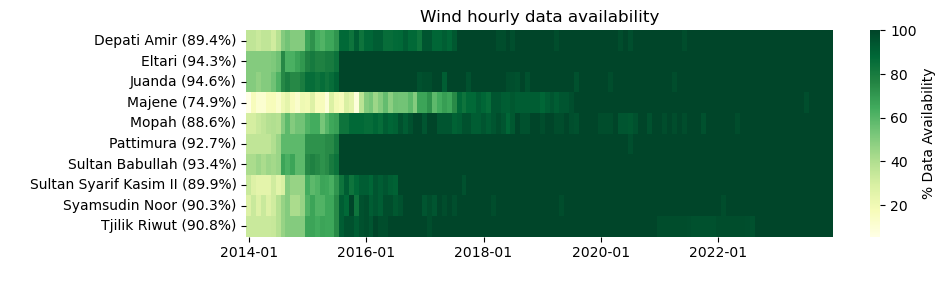

<Figure size 640x480 with 0 Axes>

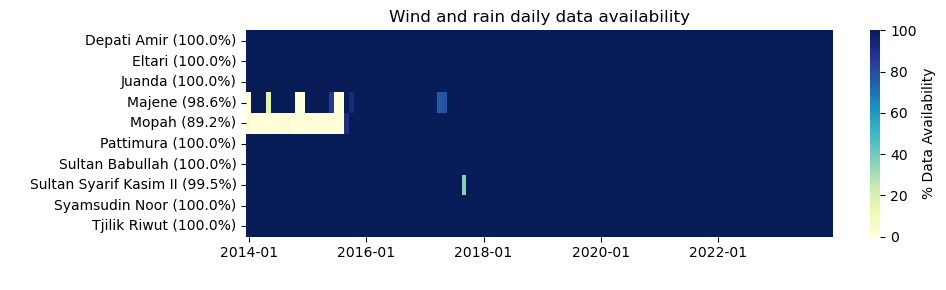

<Figure size 640x480 with 0 Axes>

In [156]:
wind_station_latlon_df = pd.read_csv('/g/data/qz03/wp3/data/obs/wind-and-rain/hourly/station_metadata.csv').drop(columns=['No']).dropna()

for timestep in ['hourly', 'daily']:
    files = [f'/g/data/qz03/wp3/data/obs/wind-and-rain/{timestep}/'+station_csv for station_csv in os.listdir(f'/g/data/qz03/wp3/data/obs/wind-and-rain/{timestep}') if 'station_metadata' not in station_csv]
    dfs = {f.split('/')[-1].replace('.csv',''): pd.read_csv(f, parse_dates=['DATA TIMESTAMP']) for f in files} if timestep == 'hourly' else {f.split('/')[-1].replace('.csv',''): pd.read_csv(f, parse_dates=['time_step']) for f in files}
    
    months_list = []
    for df in dfs.values():
        months_list.append(df['DATA TIMESTAMP'].dt.to_period('M').drop_duplicates()) if timestep == 'hourly' else months_list.append(df['time_step'].dt.to_period('M').drop_duplicates()) 
    
    all_months = pd.Index(pd.concat(months_list).drop_duplicates()).sort_values()
    
    availability = pd.DataFrame(index=dfs.keys(), columns=all_months.astype(str))
    for station, df in dfs.items():
        df['year_month'] = df['DATA TIMESTAMP'].dt.to_period('M') if timestep == 'hourly' else df['time_step'].dt.to_period('M')
        total_per_month = df.groupby('year_month').size()
        avail_per_month = df.groupby('year_month')['WIND SPEED FF'].apply(lambda x: x.notna().sum()) if timestep == 'hourly' else df.groupby('year_month')['WIND_SPEED_24H_MEAN_MS'].apply(lambda x: x.notna().sum())
        pct = (avail_per_month / total_per_month).reindex(all_months, fill_value=0) * 100
        availability.loc[station] = pct.values
        
    availability.index = availability.index.str[:5]
    new_index = []
    for station, df in dfs.items():
        total = len(df)
        available = df['WIND SPEED FF'].notna().sum() if timestep == 'hourly' else df['WIND_SPEED_24H_MEAN_MS'].notna().sum()
        percent = (available / total) * 100 if total > 0 else 0
        label = f"{wind_station_latlon_df[wind_station_latlon_df['WMO ID'] == int(station[:5])]['Station Name'].values[0]} ({percent:.1f}%)"
        new_index.append(label)
    
    availability.index = new_index
    availability.sort_index(inplace=True)
    plt.figure(figsize=(10, len(dfs)*0.05 + 2.5))
    sns.heatmap(availability.astype(float), cmap="YlGn" if timestep=='hourly' else 'YlGnBu', cbar_kws={'label': '% Data Availability'}, xticklabels=24)
    plt.title(f"{'Wind' if timestep == 'hourly' else 'Wind and rain'} {timestep} data availability")
    plt.ylabel(' ')
    plt.xlabel(' ')
    plt.tight_layout()
    plt.show()
    plt.clf()

In [164]:
wind_station_latlon_df.sort_values(by='Station Name', inplace=True)
wind_station_latlon_df['status'] = [1, 1, 1, 2, 2, 1, 1, 2, 1, 1]

In [165]:
wind_station_latlon_df

,Station Name,WMO ID,Lon,Lat,status
1,Depati Amir,96237.0,106.13000,-2.17000,1
6,Eltari,97372.0,123.67039,-10.16780,1
4,Juanda,96935.0,112.78330,-7.38460,1
5,Majene,97120.0,118.98054,-3.55074,2
9,Mopah,97980.0,140.41568,-8.52019,2
8,Pattimura,97724.0,128.09570,-3.71140,1
7,Sultan Babullah,97430.0,127.38000,0.83330,1
0,Sultan Syarif Kasim II,96109.0,101.44743,0.45924,2
3,Syamsudin Noor,96685.0,114.75400,-3.44200,1
2,Tjilik Riwut,96655.0,113.95000,-2.22000,1


### Domain plot with elevation

In [157]:
barra_topo = xr.open_dataset(f'{barraR2_dir}fx/orog/v20231001/orog_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1.nc').sel(lat=slice(domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']), lon=slice(domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max']))

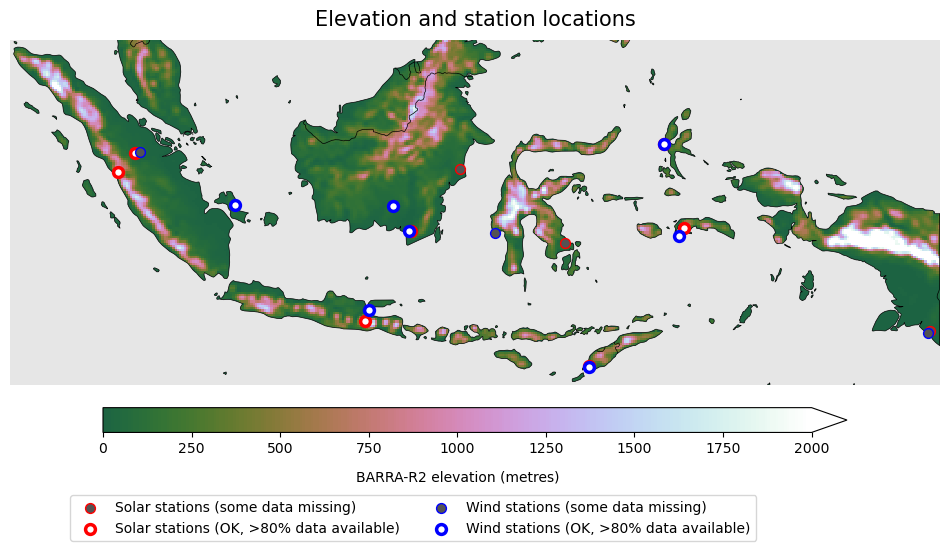

<Figure size 640x480 with 0 Axes>

In [168]:
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
contour = barra_topo.orog.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), vmax=2000, cmap=mcolors.LinearSegmentedColormap.from_list('trunc', plt.get_cmap('cubehelix')(np.linspace(5/17, 1, 256))), add_colorbar=False)
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', extend='max', shrink=0.8, aspect=30, pad=0.05)
cbar.set_label('BARRA-R2 elevation (metres)', labelpad=10)
ax.set_title("Elevation and station locations", size=15, pad=10)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='black', zorder=10, alpha=1)
ax.add_feature(cfeature.LAND, linewidth=0.5, edgecolor='black', facecolor='none', zorder=10, alpha=1)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='#e6e6e6', alpha=1)
ax.set_frame_on(False)

ax.scatter(solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 2, 'Lon'], solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 2, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='#545353', edgecolor='red', s=50, linewidth=1, label='Solar stations (some data missing)', zorder=20)
ax.scatter(solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 1, 'Lon'], solar_station_latlon_df.loc[solar_station_latlon_df['status'] == 1, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='white', edgecolor='red', s=50, linewidth=2.5, label='Solar stations (OK, >80% data available)', zorder=20)

ax.scatter(wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 2, 'Lon'], wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 2, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='#545353', edgecolor='blue', s=50, linewidth=1, label='Wind stations (some data missing)', zorder=20)
ax.scatter(wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 1, 'Lon'], wind_station_latlon_df.loc[wind_station_latlon_df['status'] == 1, 'Lat'], transform=ccrs.PlateCarree(), marker='o', color='white', edgecolor='blue', s=50, linewidth=2.5, label='Wind stations (OK, >80% data available)', zorder=20)

ax.legend(ncol=2, bbox_to_anchor=(0.81, -0.3))
plt.show()
plt.clf()